# Defining, compiling, and running stencils

This notebook demonstrates how stencils can be defined, compiled and executed.

## Configuration

First, let's define the configuration such as the size of the computational domain as well as the number of halo points and the GT4Py backend we are using.

In [1]:
nx = 20
ny = 20
nz = 79
nhalo = 3
backend = "numpy"

## Stencil definition using GT4Py

Next, we'll define the actual stencil that we want to compile and run. We use the GT4Py domain-specific language (GTScripts) for this. For demonstration purposes, we start with a very simple stencil that simply sets a field to a constant value at every grid cell.

In [2]:
from gt4py.cartesian.gtscript import PARALLEL, computation
from pace.dsl.typing import FloatField

def set_field_to_value_def(f: FloatField, value: float):
    with computation(PARALLEL), interval(...):
        f = value

## Setup helpers for building stencils

The `pace.dsl` package contains provides a helper class for compiling stencils. The helper class is called a stencil factory. In order to setup a stencil factory, several configuration objects have to be defined and passed in.

- `DaceConfig`: configuration of DaCe backend
- `CompilationConfig`: specification of how to compile
- `StencilConfig`: wrapper to carry DaCe and compilation configuration
- `GridIndexing`: helper class which provides indexing (e.g. compute domain and origin)
- `StencilFactory`: helper class to build stencils from GT4Py stencil definitions

In [3]:
from pace.dsl.dace.dace_config import DaceConfig, DaCeOrchestration
from pace.dsl.stencil import GridIndexing, StencilConfig, StencilFactory
from pace.dsl.stencil_config import CompilationConfig, RunMode

dace_config = DaceConfig(
    communicator=None, backend=backend, orchestration=DaCeOrchestration.Python
)

compilation_config = CompilationConfig(
    backend=backend,
    rebuild=True,
    validate_args=True,
    format_source=False,
    device_sync=False,
    run_mode=RunMode.BuildAndRun,
    use_minimal_caching=False,
)

stencil_config = StencilConfig(
    compare_to_numpy=False,
    compilation_config=compilation_config,
    dace_config=dace_config,
)

grid_indexing = GridIndexing(
    domain=(nx, ny, nz),
    n_halo=nhalo,
    south_edge=True,
    north_edge=True,
    west_edge=True,
    east_edge=True,
)

stencil_factory = StencilFactory(config=stencil_config, grid_indexing=grid_indexing)

## Wrap stencil into a Python class

Using the stencil factory we can now wrap the compiled GT4Py stencil into a Python class. The init section is responsible for compiling the stencil, the call section will simply execute the compiled stencil with the arguments passed.

In [4]:
from pace.dsl.stencil import StencilFactory
from pace.dsl.typing import FloatField


class SetFieldToValue:
    def __init__(self, stencil_factory: StencilFactory):
        grid_indexing = stencil_factory.grid_indexing
        self._set_field_to_value_stencil = stencil_factory.from_origin_domain(
            set_field_to_value_def,
            origin=grid_indexing.origin_compute(),
            domain=grid_indexing.domain_compute(),
        )

    def __call__(
        self,
        f: FloatField,
        value: float,
    ):
        self._set_field_to_value_stencil(f, value)

## Compiling and running the stencil

To compile and run the stencil we first have to instanciate the wrapper class. This will compile the stencil and return a callable object. Next we have to define a GT4Py data storage (field). This could also be done using the `pace.util.Quantity` class, but here we use plain GT4Py data storages for simplicity. Finally, we can call the stencil and pass in the field and value.

In [5]:
set_field_to_value = SetFieldToValue(stencil_factory)

In [6]:
import gt4py.storage as gt_storage

field = gt_storage.zeros(
    backend=backend,
    dtype=float,
    shape=(nx + 2 * nhalo, ny + 2 * nhalo, nz),
)

In [7]:
value = 42.0
set_field_to_value(field, value)

Min and max values: 42.0 0.0


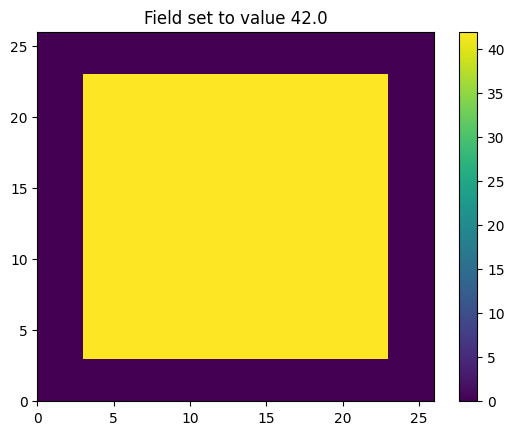

In [8]:
import matplotlib.pyplot as plt

print("Min and max values:", field.max(), field.min())

fig = plt.figure()
fig.patch.set_facecolor("white")
ax = fig.add_subplot(111)
ax.set_facecolor(".4")

f1 = ax.pcolormesh(field[:, :, 0])

cbar = plt.colorbar(f1)
ax.set_title("Field set to value %.1f" % value)
plt.show()

## Building and Running Pre-defined Stencils for Tracer Advection

In this portion, we build and run the stencils required for calculating tracer advection. This will include:
- `FiniteVolumeFluxPrep`: calculates/updates Courant number and total mass flux fields based on input wind field.
- `FiniteVolumeTransport`: calculates tracer fluxes for horizontal finite volume flux transport.
- `TracerAdvection`: performs horizontal advection on tracers.

In [9]:
import ipyparallel as ipp

layout = (1, 1)
ntiles = 6
# spinup cluster of MPI-workers
num_ranks = ntiles * layout[0] * layout[1]

tracer_center = (0, 0)
test_case = "b"
timestep = 900.0

cluster = ipp.Cluster(engines="mpi", n=num_ranks).start_and_connect_sync()

# broadcast configuration to all workers
ar = cluster[:].push(
    {
        "ntiles": ntiles,
        "nx": nx,
        "ny": ny,
        "nz": nz,
        "nhalo": nhalo,
        "layout": layout,
        "backend": backend,
        "tracer_center": tracer_center,
        "test_case": test_case,
        "timestep": timestep
    }
)

# start executing cells on the workers in parallel from here on
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04engine/s]
%autopx enabled


### Getting initial state

Before we can build and run stencils associated with tracer advection, we need to have the grid configuration and initial fields for u- and v- winds on the C grid. 

More details on these processes are described in `grid_generation.ipynb` and `initial_condition_definition.ipynb`, and here they are shortened by using helper functions inside `functions.py`.

In [10]:
import functions as func
from mpi4py import MPI
import importlib

importlib.reload(func)

mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank()

namelist_dict = func.store_namelist_variables(locals())
dimensions = func.define_dimensions(namelist_dict)

domain_configuration = func.configure_domain(mpi_comm, dimensions)

initial_state = func.create_initial_state_advection(
    domain_configuration["metric_terms"], dimensions, tracer_center, test_case
)

%px:   0%|                                                                                                                                          | 0/6 [00:01<?, ?tasks/s]

[output:1]

[output:4]

[output:3]

%px:   0%|                                                                                                                                          | 0/6 [00:02<?, ?tasks/s]

[output:5]

%px:   0%|                                                                                                                                          | 0/6 [00:02<?, ?tasks/s]

[output:2]

[output:0]

%px:   0%|                                                                                                                                          | 0/6 [00:05<?, ?tasks/s]

[stderr:2] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:5] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


%px: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05tasks/s]


For the stencils used in the tracer advection process, we will need some additional classes, such as `DampingCoefficients` and `GridIndexing`.

If we want to run tracer advection in a single layer instead of extending it to 79 identical conditions, we want to create `GridData` with the `single_layer=True`.

In [11]:
from pace.dsl.dace.dace_config import DaceConfig, DaCeOrchestration
from pace.dsl.stencil import GridIndexing, StencilConfig, StencilFactory
from pace.dsl.stencil_config import CompilationConfig, RunMode
from pace.util.grid import AngleGridData, ContravariantGridData, DampingCoefficients, GridData, HorizontalGridData, MetricTerms, VerticalGridData


if nz == 1:
    single_layer = True
else:
    single_layer = False

if single_layer:
    horizontal_grid_data = HorizontalGridData.new_from_metric_terms(domain_configuration["metric_terms"])
    vertical_grid_data = VerticalGridData(ptop=0, ks=0, ak=[10], bk=[0], p_ref=0)
    contravariant_grid_data = ContravariantGridData.new_from_metric_terms(domain_configuration["metric_terms"])
    angle_grid_data = AngleGridData.new_from_metric_terms(domain_configuration["metric_terms"])

    grid_data = GridData(horizontal_grid_data, vertical_grid_data, contravariant_grid_data, angle_grid_data)
    
else:
    grid_data = GridData.new_from_metric_terms(domain_configuration["metric_terms"])


damping_coefficients = DampingCoefficients.new_from_metric_terms(domain_configuration["metric_terms"])

dace_config = DaceConfig(
    communicator=None, backend=backend, orchestration=DaCeOrchestration.Python
)

compilation_config = CompilationConfig(
    backend=backend,
    rebuild=True,
    validate_args=True,
    format_source=False,
    device_sync=False,
    run_mode=RunMode.BuildAndRun,
    use_minimal_caching=False,
    communicator=domain_configuration["communicator"],
)

stencil_config = StencilConfig(
    compare_to_numpy=False,
    compilation_config=compilation_config,
    dace_config=dace_config,
)

grid_indexing = GridIndexing.from_sizer_and_communicator(
    sizer=domain_configuration["sizer"], cube=domain_configuration["communicator"]
)

stencil_factory = StencilFactory(config=stencil_config, grid_indexing=grid_indexing)


### 1. Finite Volume Flux Prep

In order to run the stencil, we first need to build it (initialize an instance of the class). 

For building the `FiniteVolumeFluxPrep` stencil, we need `stencil_factory` and `grid_data` from the configuration dictionary. 

For running the stencil, we require the following inputs:
- `uc (in)`: covariant x-velocity on the C-grid (stored in `initial_state` as `u_Cgrid`)
- `vc (in)`: covariant y-velocity on the C-grid (stored in `initial_state` as `v_Cgrid`)
- `crx (out)`: Courant number, x-direction
- `cry (out)`: Courant number, y-direction
- `x_area_flux (out)`: flux of area in x-direction, in units of m^2
- `y_area_flux (out)`: flux of area in y-direction, in units of m^2
- `uc_contra (out)`: contravariant x-velocity on C-grid
- `vc_contra (out)`: contravariant y-velocity on C-grid
- `dt (in)`: acoustic timestep in seconds

We need to create empty storages or quantities to initialize the output variables, and their values get updated when we run the stencil.
We plot the empty storage of `crx` on the first (zeroth) rank, run `FiniteVolumeFluxPrep`, then plot the updated storage for comparison.

%px:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 5/6 [00:05<00:00,  2.48tasks/s]

[output:0]

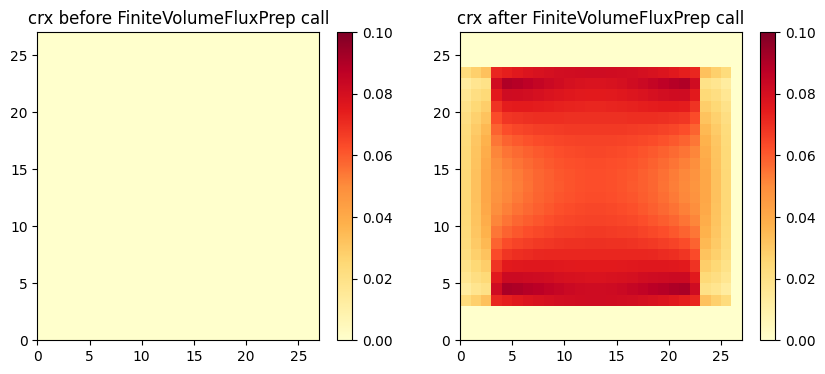

%px: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.10tasks/s]


In [12]:
import copy as cp
import matplotlib.pyplot as plt
from pace.fv3core.stencils.fxadv import FiniteVolumeFluxPrep
from units_config import units

fvf_prep = FiniteVolumeFluxPrep(
    stencil_factory, grid_data
)

crx = domain_configuration["quantity_factory"].zeros(
    dims=("x_interface", "y", "z"), units=units["courant"], dtype="float"
)
cry = domain_configuration["quantity_factory"].zeros(
    dims=("x", "y_interface", "z"), units=units["courant"], dtype="float"
)

x_area_flux = domain_configuration["quantity_factory"].zeros(
    dims=("x_interface", "y", "z"), units=units["area"], dtype="float"
)
y_area_flux = domain_configuration["quantity_factory"].zeros(
    dims=("x", "y_interface", "z"), units=units["area"], dtype="float"
)

uc_contra = domain_configuration["quantity_factory"].zeros(
    dims=("x_interface", "y", "z"), units=units["wind"], dtype="float"
)
vc_contra = domain_configuration["quantity_factory"].zeros(
    dims=("x", "y_interface", "z"), units=units["wind"], dtype="float"
)

crx_before = cp.deepcopy(crx)

fvf_prep(
    initial_state["u_cgrid"],
    initial_state["v_cgrid"],
    crx,
    cry,
    x_area_flux,
    y_area_flux,
    uc_contra,
    vc_contra,
    timestep,
)

if mpi_rank == 0:
    fig = plt.figure(figsize=(10, 4))
    fig.patch.set_facecolor("white")
    ax_before = fig.add_subplot(121)
    ax_after = fig.add_subplot(122)

    f1 = ax_before.pcolormesh(
        crx_before.data[:, :, 0], vmin=-0, vmax=0.1, cmap="YlOrRd"
    )
    plt.colorbar(f1, ax=ax_before)
    f2 = ax_after.pcolormesh(crx.data[:, :, 0], vmin=-0, vmax=0.1, cmap="YlOrRd")
    plt.colorbar(f2, ax=ax_after)

    ax_before.set_title("crx before FiniteVolumeFluxPrep call")
    ax_after.set_title("crx after FiniteVolumeFluxPrep call")
    plt.show()

Since our layer have thickness of delp Pa, we can use that information and the `x_area_flux` and `y_area_flux` variables provided by `FiniteVolumeFluxPrep` to calculate mass fluxes that are required as input to `TracerAdvection`.

We are assuming that density is 1 (kg /m3).

In [13]:
mfxd = domain_configuration["quantity_factory"].zeros(
    dims=("x_interface", "y", "z"), units=units["mass"], dtype="float"
)
mfyd = domain_configuration["quantity_factory"].zeros(
    dims=("x", "y_interface", "z"), units=units["mass"], dtype="float"
)

density = 1.0

mfxd.data[:] = x_area_flux.data[:] * initial_state["delp"].data[:] * density
mfyd.data[:] = y_area_flux.data[:] * initial_state["delp"].data[:] * density


### 2. Tracer Advection and its Inputs

In order to build the  `TracerAdvection` stencil, it needs an input of a different stencil, `FiniteVolumeTransport`. 

For building the `FiniteVolumeTransport` stencil, we need `stencil_factory`, `grid_data`, and `damping_coefficients` from the configuration dictionary. We do not actually need to run it, as it get run within `TracerAdvection`, but if we did, we would get output tracer mass fluxes. 

For building `TracerAdvection`, we need `stencil_factory`, the pre-built `FiniteVolumeTransport` stencil, `grid_data`, and the cubed-sphere communicator stored under configuration as `communicator`. We also need a dictionary that includes all the tracers we want to follow at their initial state.

<!-- For running the stencul, we require the following inputs:
- `uc (in)`: covariant x-velocity on the C-grid (stored in `initial_state` as `u_Cgrid`)
- `vc (in)`: covariant y-velocity on the C-grid (stored in `initial_state` as `v_Cgrid`)
- `crx (out)`: Courant number, x-direction
- `cry (out)`: Courant number, y-direction
- `x_area_flux (out)`: flux of area in x-direction, in units of m^2
- `y_area_flux (out)`: flux of area in y-direction, in units of m^2
- `uc_contra (out)`: contravariant x-velocity on C-grid
- `vc_contra (out)`: contravariant y-velocity on C-grid
- `dt (in)`: acoustic timestep in seconds

We need to create empty storages or quantities to initialize the output variables, and their values get updated when we run the stencil.
We plot the empty storage of `crx` on the first (zeroth) rank, run `FiniteVolumeFluxPrep`, then plot the updated storage for comparison. -->

In [14]:
from pace.fv3core.stencils.fvtp2d import FiniteVolumeTransport
from pace.fv3core.stencils.tracer_2d_1l import TracerAdvection

grid_type = 0  # cubed-sphere
hord = 6  # horizontal diffusion order

tracers = {"tracer": initial_state["tracer"]}

fvtp_2d = FiniteVolumeTransport(
    stencil_factory,
    domain_configuration["quantity_factory"],
    grid_data,
    damping_coefficients,
    grid_type,
    hord,
)

tracer_advection = TracerAdvection(
    stencil_factory,
    domain_configuration["quantity_factory"],
    fvtp_2d,
    grid_data,
    domain_configuration["communicator"],
    tracers,
)

%px: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.58s/tasks]


To run a single step of `TracerAdvection`, we need to provide it the following inputs:
- `tracers`: a dictionary of all tracers we want to advect
- `delp`: pressure thickness of layers
- `mfxd`: mass flux in the x-direction
- `mfyd`: mass flux in the y-direction
- `crx`: Courant number in the x-direction
- `cry`: Courant number in the y-direction
- `timestep`: the timestep that is applied. 

Within `TracerAdvection`, the time step is split into 3 equal sub-steps, and all fields are divided by three, then advection is calculated for each of the substeps. 

All fields but `delp` are updated. Mass fluxes and Courant numbers are divided by 3 and then returned. So if we want to continue advecting with the initial wind field, we actually need to re-set those fields to initial conditions after each step.

In [15]:
tracer_initial = cp.deepcopy(tracers)
mfxd_initial = cp.deepcopy(mfxd)
mfyd_initial = cp.deepcopy(mfyd)
crx_initial = cp.deepcopy(crx)
cry_initial = cp.deepcopy(cry)

tracer_state = [tracer_initial["tracer"]]

nSteps = 10

for step in range(nSteps):
    tracer_advection(tracers, initial_state["delp"], mfxd, mfyd, crx, cry)

    tracer_state.append(tracers["tracer"])

    mfxd = cp.deepcopy(mfxd_initial)
    mfyd = cp.deepcopy(mfyd_initial)
    crx = cp.deepcopy(crx_initial)
    cry = cp.deepcopy(cry_initial)

[stderr:0] [4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expecte

[stderr:1] [4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expecte

[stderr:3] [4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expecte

[stderr:2] [4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expecte

[stderr:5] [4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expecte

[stderr:4] [4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expecte

[output:0]

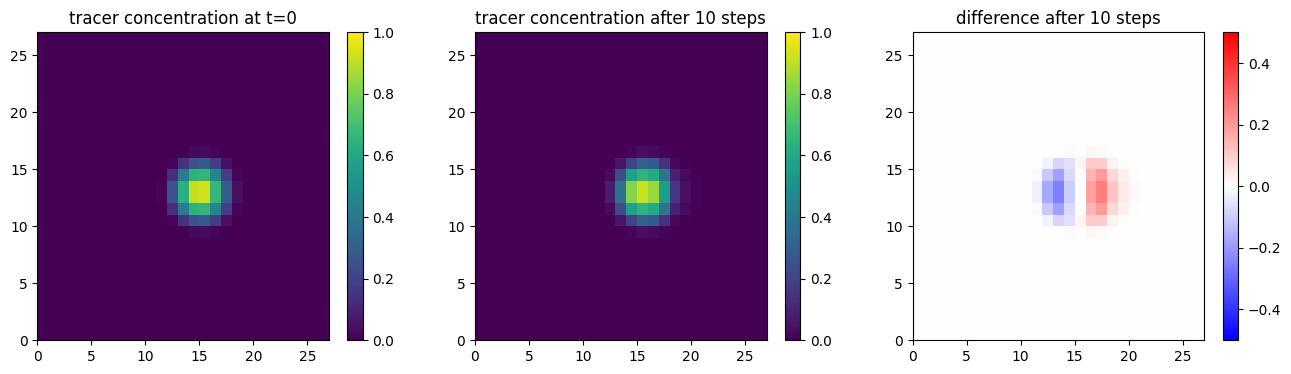

In [16]:
if mpi_rank == 0:
    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_facecolor("white")
    ax_before = fig.add_subplot(131)
    ax_after = fig.add_subplot(132)
    ax_diff = fig.add_subplot(133)

    f1 = ax_before.pcolormesh(
        tracer_state[0].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f1, ax=ax_before)
    f2 = ax_after.pcolormesh(
        tracer_state[-1].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f2, ax=ax_after)
    f3 = ax_diff.pcolormesh(
        (tracer_state[-1].data[:, :, 0] - tracer_state[0].data[:, :, 0]).T,
        vmin=-0.5,
        vmax=0.5,
        cmap="bwr",
    )
    plt.colorbar(f3, ax=ax_diff)

    ax_before.set_title("tracer concentration at t=0")
    ax_after.set_title("tracer concentration after %s steps" % nSteps)
    ax_diff.set_title("difference after %s steps" % nSteps)
    plt.show()

## Recreating this with functions.py

You can reproduce the above steps in a more succinct manner by using the following syntax.

In this case, we are using 79 layers, and things are not as fast as they could be - the same calculation is repeated at every vertical level.

In [17]:
mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank()

nz = 79
if nz == 1:
    single_layer = True
else:
    single_layer = False

namelist_dict = func.store_namelist_variables(locals())
dimensions = func.define_dimensions(namelist_dict)


domain_configuration = func.configure_domain(mpi_comm, dimensions, single_layer=single_layer)

initial_state = func.create_initial_state_advection(
    domain_configuration["metric_terms"], dimensions, tracer_center, test_case
)

stencil_configuration = func.configure_stencil(domain_configuration, backend=backend)
stencil_configuration["quantity_factory"] = domain_configuration["quantity_factory"]

tracer_advection_data, tracer_advection = func.prepare_everything_for_advection(
    stencil_configuration, initial_state, dimensions, timestep
)

tracer_advection_data_initial = cp.deepcopy(tracer_advection_data)

tracer_state = [cp.deepcopy(tracer_advection_data_initial["tracers"]["tracer"])]

nSteps = 10
for step in range(nSteps):
    tracer_advection_data = func.run_advection_step_with_reset(
        tracer_advection_data_initial, tracer_advection_data, tracer_advection
    )

    tracer_state.append(cp.deepcopy(tracer_advection_data["tracers"]["tracer"]))


[stderr:5] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno = 1
[4d6ab76db141:01394] Read -1, expected 37920, errno 

[stderr:2] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno = 1
[4d6ab76db141:01391] Read -1, expected 37920, errno 

%px:   0%|                                                                                                                                          | 0/6 [00:12<?, ?tasks/s]

[stderr:1] [4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expected 37920, errno = 1
[4d6ab76db141:01390] Read -1, expecte

[stderr:3] [4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expected 37920, errno = 1
[4d6ab76db141:01392] Read -1, expecte

[stderr:4] [4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expected 37920, errno = 1
[4d6ab76db141:01393] Read -1, expecte

%px:   0%|                                                                                                                                          | 0/6 [00:12<?, ?tasks/s]

[stderr:0] [4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expected 37920, errno = 1
[4d6ab76db141:01389] Read -1, expecte

%px: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.34s/tasks]


[output:0]

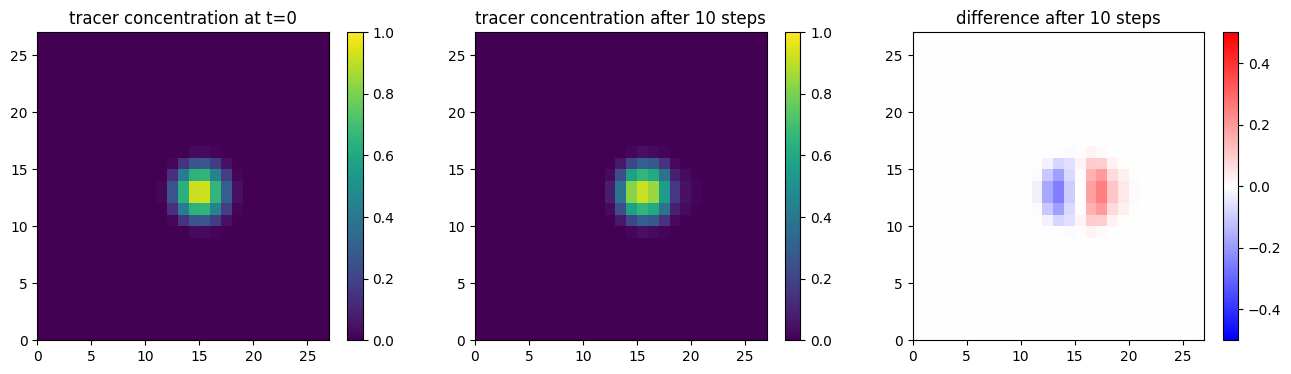

In [18]:
if mpi_rank == 0:
    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_facecolor("white")
    ax_before = fig.add_subplot(131)
    ax_after = fig.add_subplot(132)
    ax_diff = fig.add_subplot(133)

    f1 = ax_before.pcolormesh(
        tracer_state[0].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f1, ax=ax_before)
    f2 = ax_after.pcolormesh(
        tracer_state[-1].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f2, ax=ax_after)
    f3 = ax_diff.pcolormesh(
        (tracer_state[-1].data[:, :, 0] - tracer_state[0].data[:, :, 0]).T,
        vmin=-0.5,
        vmax=0.5,
        cmap="bwr",
    )
    plt.colorbar(f3, ax=ax_diff)

    ax_before.set_title("tracer concentration at t=0")
    ax_after.set_title("tracer concentration after %s steps" % nSteps)
    ax_diff.set_title("difference after %s steps" % nSteps)
    plt.show()

For a faster calculation, we can set the number of vertical levels to 1. This will increase computation speed more significantly once we add more time steps, or more points in the x- and y- dimensions. 

In [22]:
mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank()

nz = 1
if nz == 1:
    single_layer = True
else:
    single_layer = False

namelist_dict = func.store_namelist_variables(locals())
dimensions = func.define_dimensions(namelist_dict)


domain_configuration = func.configure_domain(mpi_comm, dimensions, single_layer=single_layer)

initial_state = func.create_initial_state_advection(
    domain_configuration["metric_terms"], dimensions, tracer_center, test_case
)

stencil_configuration = func.configure_stencil(domain_configuration, backend=backend)
stencil_configuration["quantity_factory"] = domain_configuration["quantity_factory"]

tracer_advection_data, tracer_advection = func.prepare_everything_for_advection(
    stencil_configuration, initial_state, dimensions, timestep
)

tracer_advection_data_initial = cp.deepcopy(tracer_advection_data)

tracer_state = [cp.deepcopy(tracer_advection_data_initial["tracers"]["tracer"])]

nSteps = 10
for step in range(nSteps):
    tracer_advection_data = func.run_advection_step_with_reset(
        tracer_advection_data_initial, tracer_advection_data, tracer_advection
    )

    tracer_state.append(cp.deepcopy(tracer_advection_data["tracers"]["tracer"]))


[stderr:2] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:5] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


%px: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:46<00:00,  7.80s/tasks]


[output:0]

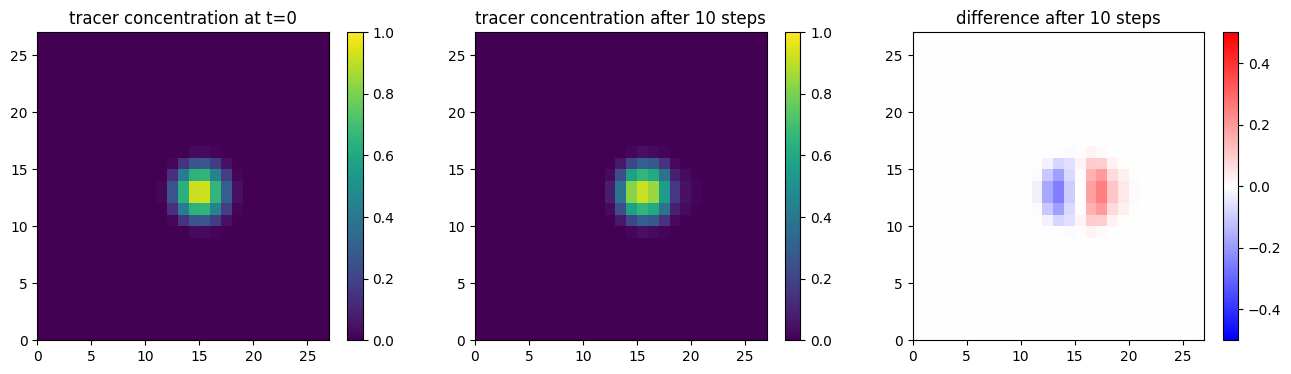

In [23]:
if mpi_rank == 0:
    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_facecolor("white")
    ax_before = fig.add_subplot(131)
    ax_after = fig.add_subplot(132)
    ax_diff = fig.add_subplot(133)

    f1 = ax_before.pcolormesh(
        tracer_state[0].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f1, ax=ax_before)
    f2 = ax_after.pcolormesh(
        tracer_state[-1].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f2, ax=ax_after)
    f3 = ax_diff.pcolormesh(
        (tracer_state[-1].data[:, :, 0] - tracer_state[0].data[:, :, 0]).T,
        vmin=-0.5,
        vmax=0.5,
        cmap="bwr",
    )
    plt.colorbar(f3, ax=ax_diff)

    ax_before.set_title("tracer concentration at t=0")
    ax_after.set_title("tracer concentration after %s steps" % nSteps)
    ax_diff.set_title("difference after %s steps" % nSteps)
    plt.show()